# Projekt DL grupy RUNDOOM

Celem projektu było utworzenie modelu/i DL wskazujących kategorię wiadomości w oparciu o nagłówek i/lub krótki opis.

News Category Dataset
https://www.kaggle.com/rmisra/news-category-dataset

### Pobranie i przygotowania danych

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras import optimizers

plt.style.use('ggplot')

data = pd.read_json('../News_Category_Dataset_v2.json', orient='values', lines=True)

# Łączenie podobnych kategorii

categories_to_combine = [('WORLDPOST', 'THE WORLDPOST'),
                       ('ARTS & CULTURE', 'ARTS'),
                       ('ARTS & CULTURE', 'CULTURE & ARTS'),
                       ('STYLE & BEAUTY', 'STYLE'),
                       ('FOOD & DRINK', 'TASTE'),
                       ('PARENTING', 'PARENTS'),
                       ('BUSINESS', 'MONEY')]

for pair_to_combine in categories_to_combine:
    data.category.apply(lambda x: pair_to_combine[0] if x == pair_to_combine[1] else x)

# Ograniczenie zakresu czasowego danych do roku 2012
data = data.loc[data['date'].dt.year == 2012]

num_categories = len(set(data.category))
names_categories = set(data.category)

# Łączenie kolumn headline i short_description
X = (data['headline'] + ' ' + data['short_description']).values
y = data['category'].values

# Przygotowanie słownika do zbierania danych wynikowych z modeli
models_val_acc = {}

### Przegląd danych po wstępnej obróbce

In [38]:
data.head()

,authors,category,date,headline,link,short_description
169498,,WELLNESS,2012-12-31,I Lost Weight: Janaye Murphy Learned From Her ...,https://www.huffingtonpost.com/entry/i-lost-we...,Got a success story of your own? Send it to us...
169499,"Jenny Isenman, Contributor\nJenny From the Blo...",PARENTING,2012-12-31,Top 10 Resolutions Anyone Can Keep,https://www.huffingtonpost.com/entry/new-years...,I'm so tired of looking back at the resolution...
169500,,WELLNESS,2012-12-31,A Month-To-Month Guide For Your Allergies,https://www.huffingtonpost.com/entry/seasonal-...,By Beth W. Orenstein If you suffer from allerg...
169501,"Francine Jay, Contributor\nAuthor",HOME & LIVING,2012-12-31,Twelve Resolutions for a Clutter-Free New Year,https://www.huffingtonpost.com/entry/twelve-re...,"Do you ever look around your home, and feel su..."
169502,"Bob Lingvall, Contributor\nSpiritual Teacher",WELLNESS,2012-12-31,"New Year's Resolutions, Enlightenment, and the...",https://www.huffingtonpost.com/entry/new-years...,Does enlightenment sound too ambitious for a N...


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31355 entries, 169498 to 200852
Data columns (total 6 columns):
authors              31355 non-null object
category             31355 non-null object
date                 31355 non-null datetime64[ns]
headline             31355 non-null object
link                 31355 non-null object
short_description    31355 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 1.7+ MB


### Model SVC

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

# Zamiana sentencji na wektory
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

models_val_acc = {'SVC': score}

print('Accuracy:', score)

Accuracy: 0.7312157162903432


### Basic DL Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 42)                1543122   
_________________________________________________________________
dropout_11 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 21)                903       
Total params: 1,544,025
Trainable params: 1,544,025
Non-trainable params: 0
_________________________________________________________________


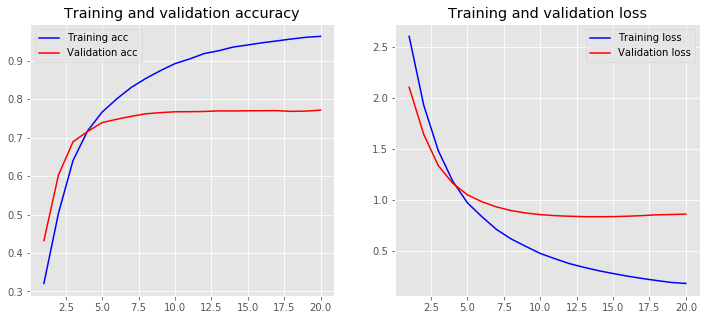

Max validation accuracy: 0.7715269803149251


In [41]:
# Zamiana zmiennej zależnej kategorycznej na postać liczbową
encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

# Zamiana zmiennej zależnej z postaci liczbowej na wektorową
dummy_y = np_utils.to_categorical(encoded_y)

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.25, random_state=100)

# Zamiana sentencji na wektory
# vectorizer = CountVectorizer(ngram_range=(1, 2))
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

optimizer = optimizers.Adam(lr=0.001)
input_dim = X_train.shape[1]

model = Sequential()
model.add(layers.Dense(42, input_dim=input_dim, activation='relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(21, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=20, verbose=0, validation_data=(X_test, y_test), batch_size=512)

model_acc = np.max(history.history['val_acc'])

models_val_acc['Basic DL'] = model_acc

plt.show()

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)
plt.show()

print('Max validation accuracy:', model_acc)

### Word Embeddings DL Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 21)           875049    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 21)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 21)                462       
_________________________________________________________________
dense_32 (Dense)             (None, 21)                462       
Total params: 875,973
Trainable params: 875,973
Non-trainable params: 0
_________________________________________________________________


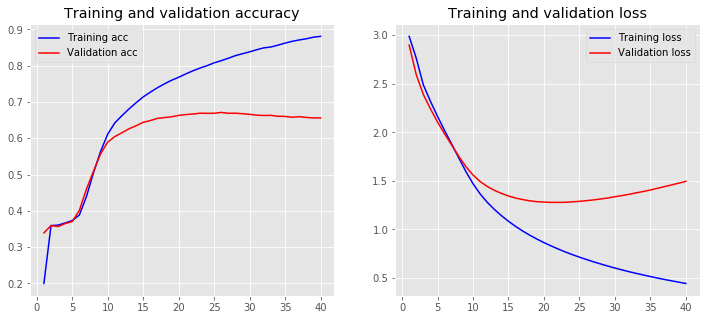

Max validation accuracy: 0.6712590892759873


In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.25, random_state=100)

# Budowanie słownika najczęściej występujących słów w sentencjach i opisach
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Zamiana sentencji na wektory
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

# Dopełnienie wektorów zerami
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 21

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(21, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=40, verbose=0, validation_data=(X_test, y_test), batch_size=512)

model_acc = np.max(history.history['val_acc'])

models_val_acc['Word Emb. DL'] = model_acc

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)
plt.show()

print('Max validation accuracy:', model_acc)

### Word Embeddings DL Model - pretrained GloVe

http://nlp.stanford.edu/data/glove.6B.zip

Pokrycie słownika przez wytrenowany model: 0.811730543089587
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           2083450   
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 50)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 21)                1071      
_________________________________________________________________
dense_34 (Dense)             (None, 21)                462       
Total params: 2,084,983
Trainable params: 2,084,983
Non-trainable params: 0
_________________________________________________________________


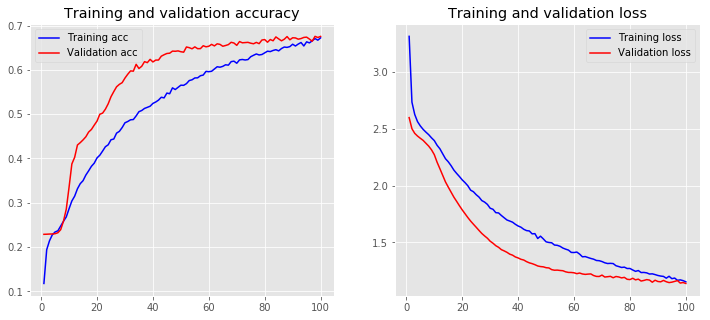

Max validation accuracy: 0.6755963772942117


In [43]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50

embedding_matrix = create_embedding_matrix(
    '../glove/glove.6B.50d.txt',  # Source: http://nlp.stanford.edu/data/glove.6B.zip
    tokenizer.word_index,
    embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Pokrycie słownika przez wytrenowany model:', nonzero_elements / vocab_size)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(21, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test), batch_size=512)

model_acc = np.max(history.history['val_acc'])

models_val_acc['GloVe DL'] = model_acc

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)
plt.show()

print('Max validation accuracy:', model_acc)

### Word Embeddings - LSTM - DL Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 21)           875049    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 60)           12480     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 60)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 21)                1281      
Total params: 888,810
Trainable params: 888,810
Non-trainable params: 0
_________________________________________________________________


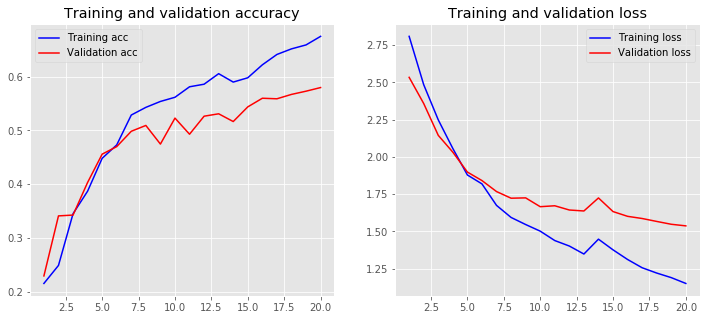

Max validation accuracy: 0.5797933410710104


In [45]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras.optimizers import Adam

from keras import backend as K
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=2, inter_op_parallelism_threads=2)))

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.25, random_state=100)

# Budowanie słownika najczęściej występujących słów w sentencjach i opisach
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Zamiana sentencji na wektory
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = 100

# Dopełnienie wektorów zerami
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 21

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=maxlen))
model.add(layers.Bidirectional(LSTM(30, return_sequences=True, use_bias=True)))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=40, verbose=0, validation_data=(X_test, y_test), batch_size=512)

model_acc = np.max(history.history['val_acc'])

models_val_acc['Word Emb. LSTM'] = model_acc

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)
plt.show()

print('Max validation accuracy:', model_acc)

### Word Embeddings -LSTM - DL Model - pretrained GloVe

http://nlp.stanford.edu/data/glove.6B.zip

Pokrycie słownika przez wytrenowany model: 0.811730543089587
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 50)           2083450   
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 50)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 21)                1071      
_________________________________________________________________
dense_37 (Dense)             (None, 21)                462       
Total params: 2,084,983
Trainable params: 2,084,983
Non-trainable params: 0
_________________________________________________________________


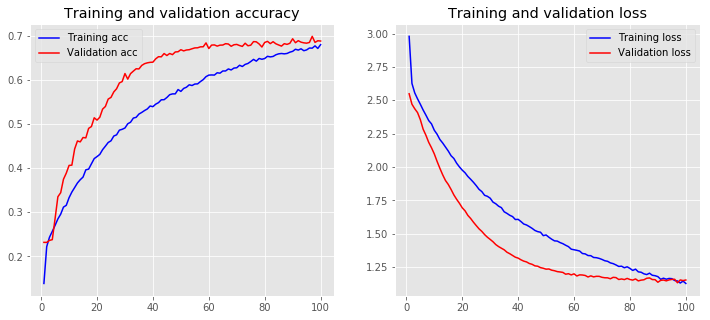

Max validation accuracy: 0.698175787834477


In [46]:
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=2, inter_op_parallelism_threads=2)))

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50

embedding_matrix = create_embedding_matrix(
    '../glove/glove.6B.50d.txt',  # Source: http://nlp.stanford.edu/data/glove.6B.zip
    tokenizer.word_index,
    embedding_dim)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Pokrycie słownika przez wytrenowany model:', nonzero_elements / vocab_size)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix],
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(21, activation='relu'))
model.add(layers.Dense(num_categories, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test), batch_size=512)

model_acc = np.max(history.history['val_acc'])

models_val_acc['GloVe LSTM DL'] = model_acc

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)
plt.show()

print('Max validation accuracy:', model_acc)

### Podsumowanie modeli

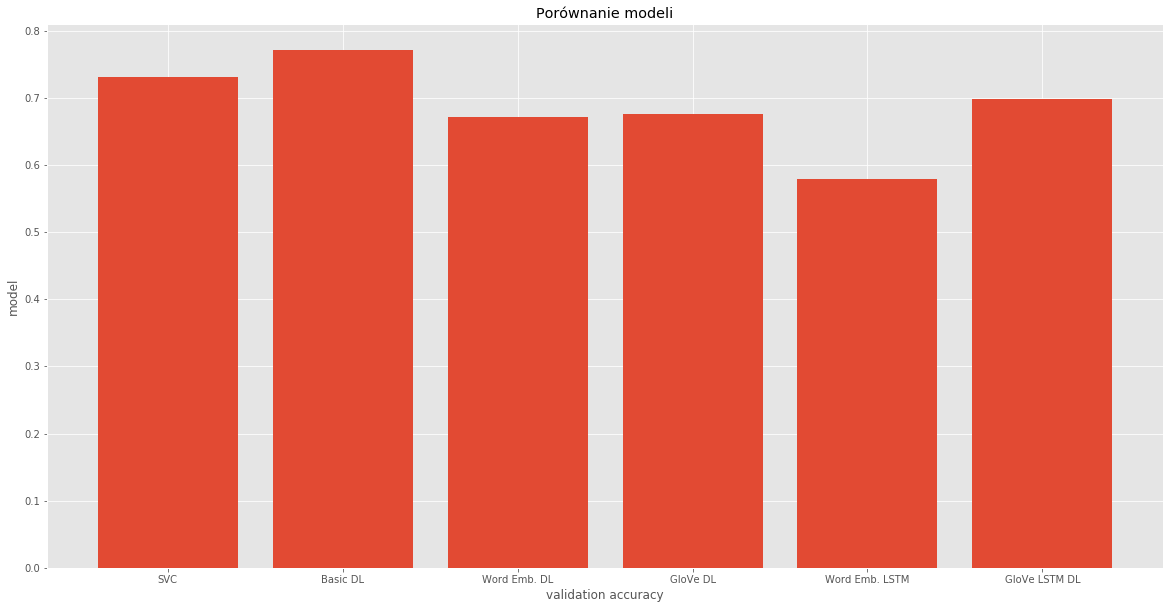

In [66]:
label = models_val_acc.keys()
accuracy = models_val_acc.values()

index = np.arange(len(label))

plt.figure(figsize=(20, 10))
plt.bar(index, accuracy)
plt.xlabel('validation accuracy')
plt.ylabel('model')
plt.xticks(index, label, rotation=0)
plt.title('Porównanie modeli')
plt.show()